Signal Processing (Part 4: Application)
---

Part นี้ จะลองเอาความรู้ทางด้าน signal processing มาเล่นกับไฟล์เสียงดู

เราเริ่มต้นด้วยการ import สิ่งที่เราจะใช้งานมา

In [1]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
from sklearn.decomposition import FastICA
import IPython
import IPython.display as ipd


Download ไฟล์เสียงผ่านคำสั่ง `wget` ซึ่งเป็นไฟล์เสียงที่จำลองสถานการณ์ต่อไปนี้

ในห้องมีคนอยู่สองคน คนแรกนั่งฟัง lecture ของ Brain Building Blocks ในขณะที่คนที่สองกำลังหัดเล่นกีตาร์ โดยไฟล์เสียงที่เราดาวน์โหลดมาจะมีสองไฟล์ ประกอบด้วย

1.   mixed_near_lecture.wav เป็นไฟล์เสียงที่อัดมาจากโทรศัพท์มือถือที่อยู่ใกล้กับคนที่ฟัง lecture อยู่

2.   mixed_near_music.wav เป็นไฟล์เสียงที่อัดมาจากโทรศัพท์มือถือที่อยู่ใกล้กับคนที่หัดเล่นกีตาร์

ทั้งสองไฟล์นี้ถูกอัดพร้อม ๆ กัน


In [2]:
!wget -O mixed_near_lecture.wav https://github.com/ichatnun/brainCodeCamp/raw/main/Fundamentals/SignalProcessing/data/mixed_near_lecture.wav
!wget -O mixed_near_music.wav https://github.com/ichatnun/brainCodeCamp/raw/main/Fundamentals/SignalProcessing/data/mixed_near_music.wav

--2023-05-15 18:28:12--  https://github.com/ichatnun/brainCodeCamp/raw/main/Fundamentals/SignalProcessing/data/mixed_near_lecture.wav
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ichatnun/brainCodeCamp/main/Fundamentals/SignalProcessing/data/mixed_near_lecture.wav [following]
--2023-05-15 18:28:12--  https://raw.githubusercontent.com/ichatnun/brainCodeCamp/main/Fundamentals/SignalProcessing/data/mixed_near_lecture.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 786278 (768K) [audio/wav]
Saving to: ‘mixed_near_lecture.wav’

mixed_near_lecture. 100%[===================>] 767.85K  --.-KB/s  

ทำการโหลดไฟล์เสียงทั้ง 2 ไฟล์มาเก็บไว้ใน variable และลองฟังเสียงที่อัดมาโดยการใช้ `IPython.display.Audio`

In [3]:
# โหลดไฟล์เสียงทั้ง 2 ไฟล์มา
mixed_near_lecture, sampling_rate = librosa.load('mixed_near_lecture.wav')
mixed_near_music, _ = librosa.load('mixed_near_music.wav')

# print sampling rate ออกมาดู
print(f"Sampling rate = {sampling_rate/1000} kHz")

# แสดงปุ่มสำหรับกดฟังเสียง
print("Near lecture")
ipd.display(IPython.display.Audio(mixed_near_lecture,rate=sampling_rate))
print("Near guitar")
ipd.display(IPython.display.Audio(mixed_near_music,rate=sampling_rate))

Sampling rate = 22.05 kHz
Near lecture


Near guitar


จากที่ได้ลองฟังเสียงดูจะเห็นว่าไฟล์เสียงทั้งสอง (mixed signals) มีเสียงอย่างน้อย 2 ชนิดผสมกัน ประกอบด้วยเสียงคนพูดและเสียงกีตาร์ (source signals) ซึ่งทั้งสองไฟล์มีความแตกต่างกันเล็กน้อยตรงที่มีความดังของเสียงคนพูดและเสียงกีตาร์ที่แตกต่างกัน

ถ้าเกิดว่าเราสนใจแยกเสียงที่มาจากแต่ละ source ใน mixed signal ออกจากกัน เราสามารถใช้เทคนิคพื้นฐาน เช่น Independent Component Analysis (ICA) ดูได้ 

โจทย์ประเภทนี้มีชื่อเรียกว่า source separation, blind signal separation หรือ blind source separation

ในตัวอย่างนี้ เราจะลองใช้ `sklearn.decomposition.FastICA` ในการแยก source signal ออกจากกันดู ว่าจะแยกสำเร็จหรือไม่ โดยเราจะกำหนดล่วงหน้าว่ามี source signals อยู่ 2 สัญญาณ


In [4]:
# กำหนดจำนวน components ที่จะใช้สำหรับ ICA
n_components = 2

# เอา mixed signals มารวมกันไว้ใน variable ที่ชื่อว่า mixed_concat
mixed_concat = np.concatenate((np.expand_dims(mixed_near_lecture, axis=-1), np.expand_dims(mixed_near_music, axis=-1)), axis=1)

# ลองใช้ ICA เพื่อพยายามแยก source signals จาก mixed signals ดู
transformer = FastICA(n_components=n_components)
source_estimated = transformer.fit_transform(mixed_concat)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


ลองฟังเสียง source signals ที่ ICA ให้มาดูกัน

In [5]:
# ลองฟังเสียงของแต่ละ source ที่ ICA ให้มา
for idx in range(n_components):

    # Normalize ทุกจุดในแต่ละ source signal ด้วยค่าสูงสุดคือค่าสัมบูรณ์ของมัน
    source_estimated[:, idx] /= np.max(np.abs(source_estimated[:, idx]))

    # แสดงปุ่มสำหรับกดฟังเสียง
    print(f"Source {idx+1}")
    ipd.display(IPython.display.Audio(source_estimated[:, idx], rate=sampling_rate))

Source 1


Source 2


ในตัวอย่างจำลองนี้ ICA สามารถแยกเสียงกีตาร์ออกจากเสียง lecture ได้ดีพอสมควร

**หมายเหตุ** 


1.   ในหลายสถานการณ์ ICA ก็ไม่สามารถแยก source แต่ละอันออกจากกัน เราอาจจะต้องพึ่งพาเทคนิคอื่น ๆ ที่มีสมมติฐานและความซับซ้อนแตกต่างกันออกไป
2.   ICA มักจะถูกนำมาใช้ในการกำจัด eye movement artifacts ออกจากข้อมูล electroencephalogram (EEG)


---
เครื่องมือที่เป็นที่นิยมสำหรับใช้ในการวิเคราะห์ไฟล์เสียง ที่เราได้ทำความรู้จักกันเล็กน้อยใน part ที่แล้ว ก็คือการดู spectrogram ซึ่งเป็นสิ่งที่ให้ข้อมูลทั้งในโดเมนเวลา และ โดเมนความถี่

เราจะมาลองดู spectrogram ของ source signals ทั้งสองกัน


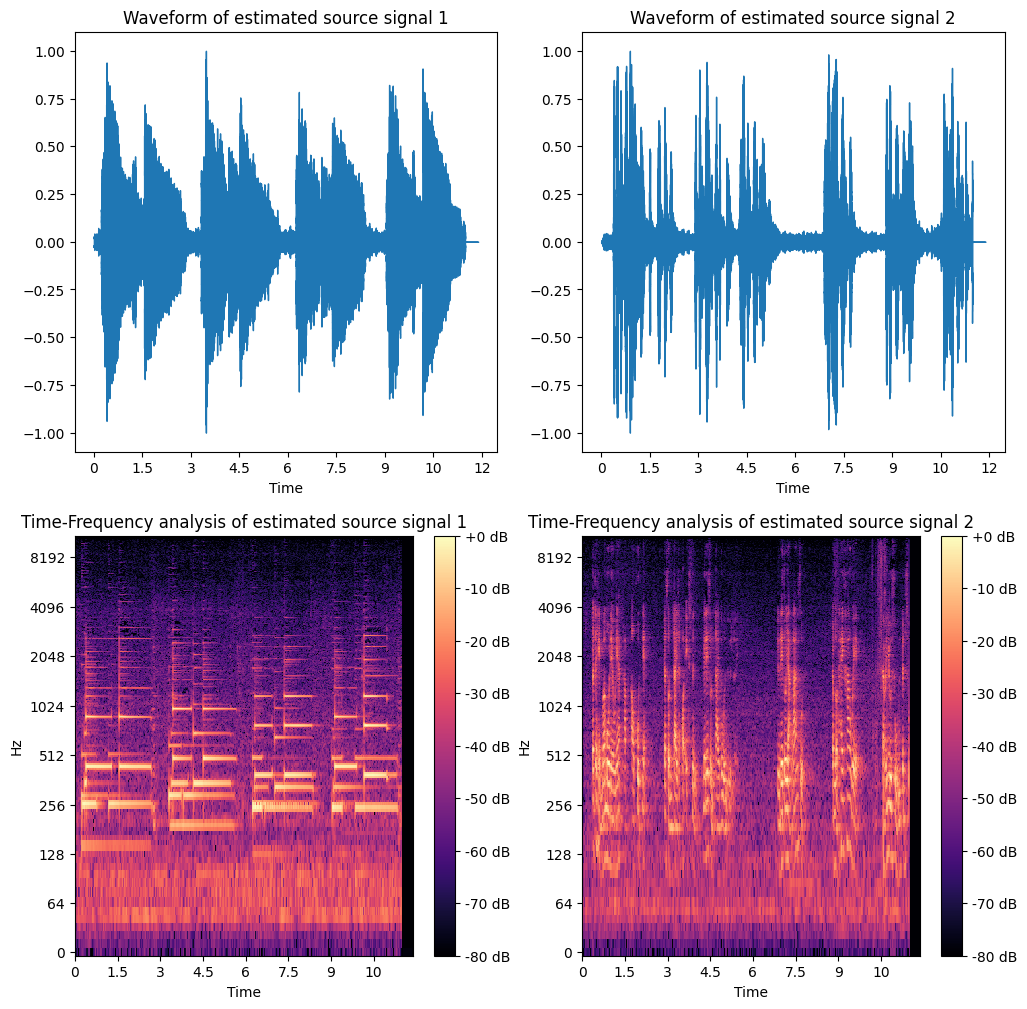

In [6]:
# แสดงไฟล์เสียงเป็นรูป waveform และ แสดงผลการวิเคราะห์ time-frequency analysis ด้วย spectrogram
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

for idx in range(n_components):

    # แสดง waveform
    librosa.display.waveshow(source_estimated[:, idx], sr=sampling_rate, ax=ax[0,idx])
    ax[0,idx].set(title=f"Waveform of estimated source signal {idx+1}")

    # แสดง spectrogram
    D = librosa.stft(source_estimated[:, idx])  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax[1,idx])
    ax[1,idx].set(title=f"Time-Frequency analysis of estimated source signal {idx+1}")
    fig.colorbar(img, ax=ax[1,idx], format="%+2.f dB")